In [137]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import matplotlib.style as style


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV


# logistic regression
from sklearn.linear_model import LogisticRegression
# knn
from sklearn.neighbors import KNeighborsClassifier
#random forest
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
#naive bayes
from sklearn.naive_bayes import MultinomialNB

# metrics  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay, roc_curve, roc_auc_score, auc,plot_roc_curve, accuracy_score, precision_score, recall_score, f1_score

# pickle
import pickle

# III. Modeling 

### Project Contents

1. [Data Cleaning](../code/1_data_cleaning.ipynb)
2. [Data Visualization](../code/2_eda.ipynb)
3. [Classifcation Model Comparison](../code/3_modeling.ipynb) [This Notebook]

---

### Notebook Purpose

This notebook uses the cleaned data from notebook 1 and fits various regression models and text pre-processors in an effort to develop a robust text classication model. 

---

Read in .CSV data

In [3]:
wsb_df = pd.read_csv('../data/wsb_df_clean.csv')
inv_df = pd.read_csv('../data/inv_df_clean.csv')

# concat both dataframes
df = pd.concat([inv_df, wsb_df], axis=0)

# Modeling Overview

At a high level, the modelling process will proceed as follows:

1. Split the data into training and testing sets.  
2. Transform the data using a Count Vectorizer or TF-IDF Vectorizer.
3. Use an iterative Random and Grid Search process to train various models and transformers to find the best model and hyperparameter tuning.
4. Use the final trained production model to determine whether the text came from r/WallStreetBets or r/Investing.

---

## Data Pre-Processing

The title and selftext features in our datasets have already been lemmatized. We will further process the documents by tokenizing them (splitting sentences into individual, constituent parts) using two different transformers, a TF-IDF Vectorizer and a Count Vectorizer. By iteratively searching over the models and transformers, we will select the transformer that yields the most superior results. 

### 1.  TF-IDF Vectorizer  

TF-IDF stands for *Term Frequency - Inverse Document Frequency* and is a statistical measure that evaluates how relevant a word is to a document or a collection of documents. ([SOURCE](https://monkeylearn.com/blog/what-is-tf-idf/)). 

It is calculated by multiplying how many times a word appears in a document by the inverse document frequency of the word across a set of documents. By doing this we can weight words by frequency and importance, such that a word that is very common in the subreddits, for example, *the*, will be ranked low even though it appears many times, and a word such as *Tesla* will be ranked higher as it has more relevance. 

### 2. Count Vectorizer

A count vectorizer is a simpler version of the TF-IDF Vectorizer. The count vectorizer simply creates a matrix of each word and its number of appearances in a collection of documents, and, unlike the TF-IDF vectorizer, does not penalize the words based on inverse document frequency. ([SOURCE](https://enjoymachinelearning.com/blog/countvectorizer-vs-tfidfvectorizer/))


## Models

In order to select the best possible model we will evaluate the effectiveness of 2 different transformers and 5 different classification models. We will evaluate the following models:

### 1. Logistic Regression

Logistic regression is used to predict the probability that an instance belongs to a certain class. It does this by using a sigmoid function, returning values between 0 and 1 that can lead to a classification. Logistic regression is powerful and somewhat intuitive, however it is sensitive to outlier values, assumes a linear relationship between the features, and requires a balance of classes. [(SOURCE)](https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/).

### 2. $k$-Nearest Neighbors

$k$-nearest neighbors renders a classification decision based on the average of a distance metric (euclidean distance or manhattan distance, etc.) amongst $k$-nearest neighbor points. The algorithm is simple and intuitive and can be powerful, however it is computationally expensive, prone to overfitting, and as it is distance based, is sensitive to scale of the features. [(SOURCE)](https://medium.com/swlh/k-nearest-neighbor-ca2593d7a3c4).

### 3. Random Forest Classifier/Extra Trees Classifer

The Random Forest Classifier is a type of decision tree algorithm. Decision trees make use *recursive partitioning*, wherein the data is repeatedly divided and subdivided with the goal of making the outcomes in each final subdivision as homogenous as possible. Homogeneity is assessed at each partition using a metric called *impurity*. For each proposed partition in the data, impurity is measured for each of the partitions that result from the split, and a weighted average is calculated. Whichever partition yields the lowest weighted average is selected. The tree stops growing when the leaves are completely pure. (Bruce, Bruce, Gedeck, *Practical Statistics for Data Scientists*, 2017)

In Random Forests, multiple decision trees are used, wherein the decision trees are trained using a random subset of the features and a random subset of the training data. Each tree within the forest is trained using bootstrapped data (randomly drawn data sampled with replacement) from the original dataset. Thus the trees are relatively uncorrelated and the un-correlated decision trees render a classification as an ensemble, with the final classification being average combination of the decision trees.

Extra trees is very similar to a Random Forest, however the bootstrapping is eschewed. The advantage of a Random Forest over Extra-Trees is increased accuracy, however at the expense of extra computational time. ([SOURCE](https://quantdare.com/what-is-the-difference-between-extra-trees-and-random-forest/)).


### 4. Naive Bayes

Naive Bayes is classification algorithm built on Bayes Theorem. Bayes' theorem is a way of calculating the probability of one (or more) event given the occurrence of another event (Conditional Probability) without knowing the probability of two (or more) simultaneous events (Joint Probability). 

For two events, $A$ and $B$, Bayes' theorem lets us go from $P(B|A)$ to $P(A|B)$ if we know the probability of an event irrespective of the outcomes of other random variables ( Marginal Probability ) of the outcomes of $A$ and the probability of $B$, given the outcomes of $A$. 
$$
P(A|B)=\frac{P(B|A)\ P(A)}{P(B)}
$$

Where:

$P(A|B)$ is referred to as the *Posterior Probability*, the conditional probability of A, given B.

$P(A)$ is referred to as the *Prior Probability*, the marginal probability of A.

$P(B|A)$ is the conditional probability of B given A.

$P(B)$ is the prior or marginal probability of B, and acts as a normalizing constant. 

Naive Bayes Classifcation works by:

1. Calculating the prior probability of each class

2. Calculating the likelihood of each feature given each class

3. Using Bayes' theorem to compute the posterior probability of each class for a given instance. 

([SOURCE](https://machinelearningmastery.com/bayes-theorem-for-machine-learning/))


---

### Hyperparameter Optimization

**Randomized Search and Grid Search For Hyperparameters**

Each of the 5 models and 2 transformers listed above have hyperparameters that can be tuned for greater model performance. 

In order to manage the tuning process in a rigorous yet practical manner we will use Randomized Search over the 5 models and 2 transformers to find the best performing model and parameters, and then pass that model into a GridSearch where we will more rigorously search over hyper parameters. Once our model and hyperparameters have been found, we will fit them to our training and test data.

Randomized Search selects hyper parameters by sampling from a distribution of possible hyperparameters, but does not exhaustively use all combinations as a Grid Search will, and therefore is more efficient. Given our large datasets, time constraints and compute power, we believe this is the most practical and rigorous way to derive an effective model. 

---

### Title vs. Selftext vs. Both

One result of the EDA conducted in [Notebook_2](code/2_eda.ipynb) was the significant difference between the words used in titles between the two subreddits, with one hypothesis being that titles alone might have better classification power than just selftext or the combination of the two. 

This possibility will be explored below. However, as the initial random search and gridsearch process is quite computationally expensive, we cannot repeat the process outlined above for titles, selftext and the combination of two. So, we will initially use all available data (combining titles and self text), search for the highest performing transformer and evaluator, and then iterate over titles only, selftext only and both to find the highest performing model. While this isn't truly exhaustive, it is the only possible approach given the resources and time constraints available to this project. 

### Train Test Split

In [4]:
# train test split
X = df['title_lemmatized'] + ' ' + df['selftext_lemmatized']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14564,), (4855,), (14564,), (4855,))

In order to avoid overfitting our models, we first split the data using the training and testing paradigm. We will use 75% of the data for training the model and the last 25% out-of-sample portion for testing and evaluation. 

### Baseline

In [6]:
y_test.value_counts(normalize=True)


wallstreetbets    0.507724
investing         0.492276
Name: subreddit, dtype: float64

We need a baseline to benchmark the predictive value of our classification models. We use a simple majority class baseline model. Above we see that the majority class, r/WallStreetBets is $.507$ % of the data, so if our model cannot attain an accuracy score of $.507$ we have no predictive power. 

---

# I. - Random Search with `TfidfVectorizer`

### Pipeline Construction

In [7]:
# pipelines for each estimator
pipe_lr = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression(solver='liblinear'))
])

pipe_knn = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

pipe_rf = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('rf', RandomForestClassifier(n_jobs=-1))
])

pipe_nb = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

pipe_et = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('et', ExtraTreesClassifier(n_jobs=-1))
])


### Hyperparameters to Search Over

In [8]:
# logistic regression
lr_params = {
    'tvec__max_features': [1000, 2000, 3000, 4000, 5000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [1.0, 1.5, 2.0]
}

# knn
knn_params = {
    'tvec__max_features': [1000, 2000, 3000, 4000, 5000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'knn__n_neighbors': [5, 10, 15, 20, 25],
    'knn__weights': ['uniform', 'distance']
}

# random forest
rf_params = {
    'tvec__max_features': [1000, 2000, 3000, 4000, 5000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [100, 200, 300, 400, 500],
    'rf__max_depth': [None, 5, 10, 15, 20],
    'rf__min_samples_split': [2, 3, 4],
    'rf__min_samples_leaf': [1, 2, 3]
}

# naive bayes
nb_params = {
    'tvec__max_features': [1000, 2000, 3000, 4000, 5000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [1.0, 1.5, 2.0]
}

# extra trees
et_params = {
    'tvec__max_features': [1000, 2000, 3000, 4000, 5000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'et__n_estimators': [100, 200, 300, 400, 500],
    'et__max_depth': [None, 5, 10, 15, 20],
    'et__min_samples_split': [2, 3, 4],
    'et__min_samples_leaf': [1, 2, 3]
}

## Hyperparameters

Hyperparameters are the various facets of a machine-learning model that can be adjusted to optimize performance. 

The above code block holds the various hyperparameter settings `RandomizedSearchCV` will search over. A brief explanation of the hyperparameters and intent follows:

**TF-IDF Hyperparameters**

`tvec_max_features` - Controls the maximum number of features (unique words or n-grams) the vectorizer will create. If we don't throttle the number of features we will easily have feature matrices that have over 60,000 columns and 10,000 rows. 

We don't have the compute power or time to process such a large amount of data so instead we will search over a range of features starting at 1,000 and scale up to 5,000 in increments of 1,000. 

`tvec_min_df` - Controls the minimum number of documents (rows in our input matrix) a word must appear in to be included as a feature. We search over a range of 2, 3 to reduce words that are not helpful. However, if we set this range too low we will introduce too much noise into the model. 

`tvec_max_df` - Controls the maximum portion of documents (selftext or titles or both) a word can appear in to be included by the vectorizer. If we lower this proportion our model includes more common words but missies important words. We will search over a proportion range of 90 to 95%. 

`tvec_ngram_range` - As explained in the EDA section in [Notebook_2](code/2_eda.ipynb), an n-gram is *a contiguous sequence of $n$ items from a given sample of text or speech* ([SOURCE](https://towardsdatascience.com/text-analysis-basics-in-python-443282942ec5)). We will search over a range of unigrams and unigrams *and* bigrams. 

**Logistic Regression Hyperparameters**

`lr_penalty` - Modifies the type of regularization used by the logistic regression model. l1 refers to $\lambda_1$ regularization, which adds penalties to the model based on the absolute value of the of the parameters, whereas l2 refers to the $\lambda_2$ penalty, which add penalties to the model based on the squared values of the model's parameters. 

`lr_C` - Modulates the strength of the regularization applied to the model. A lower value means stronger regularization and a larger value means weaker regularization. We will search over a range of 1.0 to 2.0 incrementing by .5. 

**kNN Hyperparameters**

`knn_n_neighbords` - Controls the number of "nearest neighbors" the model utilizes. A larger number will generally lead to a better fit, but also to longer compute time. We will randomly search from 5 to 25, incrementing in steps of 5. 

`knn_weights` - Controls the weight assigned to the nearest neighbor in the model. "Uniform" assigns each neighbor the same weight, whereas "Distance" assigns a weight that is inversely proportional to the distance from the query point. We will search over both. 

**Naive Bayes Hyperparameters**

`nb_alpha` - Controls the "smoothing" applied to a likelihood calculation. A larger value reduces the model's sensitivity to noise but also reduces the model's ability to fit. We will search over a range of 1 to 2 incrementing in steps of .5. 

**Random Forest and Extra Trees Hyperparameters**

`n_estimators` - Contorls the number of decision trees in the random forest. As we increase the number of trees we increase the model's complexity and compute time, we will search over a range of 100-500 incrementing in steps of 100.  

`max_depth` - Max depth in a random forest is the longest path between the root node and leaf node. The deeper the tree, more splits it has and the more complex it becomes. This increases complexity and the possibility of overfitting. We will search from 5 to 20 in steps of 5 and also pass in `None`, which allows for unlimited depth. 

`min_samples_split` - Controls the minimum number of samples required to split an internal node in a decision tree. A larger value reduces the model's fit to the data. We will search over a range of 2, 3 and 4. 

`min_samples_lead` - Controls the minimum number of samples required to be a leaf node in a decision tree. A larger value reduces the model's fit to the data. We will search over a range of 1, 2, and 3. 


---

**NOTE**

There are more hyperparameters and options to explore, however given the size of the data set (14,654 rows in the training data) and our available compute power, what we have outlined above is the best we can manage. 

Sources:

1. https://stackoverflow.com/questions/46480457/difference-between-min-samples-split-and-min-samples-leaf-in-sklearn-decisiontre
2. https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/#:~:text=The%20max_depth%20of%20a%20tree,my%20random%20forest%20to%20grow.
3. https://blog.dataiku.com/narrowing-the-search-which-hyperparameters-really-matter
4. https://towardsdatascience.com/hyperparameter-tuning-for-machine-learning-models-1b80d783b946



### Instantiate `RandomSearchCV`

In [9]:
# instantiate estimators

# logistic regression
lr_rs = RandomizedSearchCV(pipe_lr, param_distributions=lr_params, cv=5, n_iter=50, verbose=1, n_jobs=-1)
# knn
knn_rs = RandomizedSearchCV(pipe_knn, param_distributions=knn_params, cv=5, n_iter=50, verbose=1, n_jobs=-1)
# random forest
rf_rs = RandomizedSearchCV(pipe_rf, param_distributions=rf_params, cv=5, n_iter=50, verbose=1, n_jobs=-1)
# naive bayes
nb_rs = RandomizedSearchCV(pipe_nb, param_distributions=nb_params, cv=5, n_iter=50, verbose=1, n_jobs=-1)
# extra trees
et_rs = RandomizedSearchCV(pipe_et, param_distributions=et_params, cv=5, n_iter=50, verbose=1, n_jobs=-1)

The above code instantiates a randomSearch over the pipelines and hyperparameters discussed above. 

### Iterate Over Models

In [10]:
# randoms = [lr_rs, knn_rs, rf_rs, nb_rs, et_rs]

# dist_dict = {0: 'Logistic Regression', 1: 'KNN', 2: 'Random Forest', 3: 'Naive Bayes', 4: 'Extra Trees'}

# for i, random in enumerate(randoms):
#     print('Fitting', dist_dict[i])
#     random.fit(X_train, y_train)
#     print('Best score:', random.best_score_)
#     print('Best params:', random.best_params_)
#     print('Training score:', random.score(X_train, y_train))
#     print('Testing score:', random.score(X_test, y_test))
#     print('')

In [11]:
# # save models to pickle

# pickle.dump(lr_rs, open('../data/lr_rs.pkl', 'wb'))
# pickle.dump(knn_rs, open('../data/knn_rs.pkl', 'wb'))
# pickle.dump(rf_rs, open('../data/rf_rs.pkl', 'wb'))
# pickle.dump(nb_rs, open('../data/nb_rs.pkl', 'wb'))
# pickle.dump(et_rs, open('../data/et_rs.pkl', 'wb'))


The above code iterates over the pipelines holding the `TfidVectorizer`'s and evaluators and returns the results. This is a computationally expensive process and takes approximately 75 minutes to run on our machine, so the code was run once, the models saved to `.pkl` files, and then commented out. 

## Random Search I. Results

In [12]:
# open models from pickle

lr_rs = pickle.load(open('../data/lr_rs.pkl', 'rb'))
knn_rs = pickle.load(open('../data/knn_rs.pkl', 'rb'))
rf_rs = pickle.load(open('../data/rf_rs.pkl', 'rb'))
nb_rs = pickle.load(open('../data/nb_rs.pkl', 'rb'))
et_rs = pickle.load(open('../data/et_rs.pkl', 'rb'))


In [13]:
# results as dataframe
results = pd.DataFrame({
    'model': ['Logistic Regression', 'KNN', 'Random Forest', 'Naive Bayes', 'Extra Trees'],
    'best_score': [lr_rs.best_score_, knn_rs.best_score_, rf_rs.best_score_, nb_rs.best_score_, et_rs.best_score_],
    'train_score': [lr_rs.score(X_train, y_train), knn_rs.score(X_train, y_train), rf_rs.score(X_train, y_train), nb_rs.score(X_train, y_train), et_rs.score(X_train, y_train)],
    'test_score': [lr_rs.score(X_test, y_test), knn_rs.score(X_test, y_test), rf_rs.score(X_test, y_test), nb_rs.score(X_test, y_test), et_rs.score(X_test, y_test)] 
})

In [56]:
# dictionary of models
models = {
    'Logistic Regression': lr_rs,
    'KNN': knn_rs,
    'Random Forest': rf_rs,
    'Naive Bayes': nb_rs,
    'Extra Trees': et_rs
}

display(results)

# print best params for each model
for model in models:
    print(model)
    print(models[model].best_params_)
    print('')

,model,best_score,train_score,test_score
0,Logistic Regression,0.864597,0.904079,0.878476
1,KNN,0.807882,0.825803,0.808033
2,Random Forest,0.856564,0.981392,0.864882
3,Naive Bayes,0.860203,0.880047,0.866323
4,Extra Trees,0.861919,0.968484,0.866941


Logistic Regression
{'tvec__ngram_range': (1, 2), 'tvec__min_df': 2, 'tvec__max_features': 5000, 'tvec__max_df': 0.95, 'lr__penalty': 'l2', 'lr__C': 1.0}

KNN
{'tvec__ngram_range': (1, 1), 'tvec__min_df': 2, 'tvec__max_features': 4000, 'tvec__max_df': 0.95, 'knn__weights': 'uniform', 'knn__n_neighbors': 25}

Random Forest
{'tvec__ngram_range': (1, 1), 'tvec__min_df': 3, 'tvec__max_features': 4000, 'tvec__max_df': 0.95, 'rf__n_estimators': 200, 'rf__min_samples_split': 4, 'rf__min_samples_leaf': 2, 'rf__max_depth': None}

Naive Bayes
{'tvec__ngram_range': (1, 1), 'tvec__min_df': 3, 'tvec__max_features': 5000, 'tvec__max_df': 0.9, 'nb__alpha': 1.0}

Extra Trees
{'tvec__ngram_range': (1, 1), 'tvec__min_df': 2, 'tvec__max_features': 3000, 'tvec__max_df': 0.95, 'et__n_estimators': 500, 'et__min_samples_split': 2, 'et__min_samples_leaf': 3, 'et__max_depth': None}



### Random Search I. Result Analysis

We computed 50 fits and 5 folds over randomly selected hyperparameters for each of our 5 models for a total of $250 \times 5 = 1250$ fits to find the results presented above. 

We see that the top performing model was Logistic Regession with a Cross Validation accuracy score of .86, a training accuracy score of .90 and a test score of .87. The spread between the three scores suggests that while slightly overfit, the model generalizes well to unseen data. The worst performing model was KNN with a cross validation score of .80 a training score of .82 and a testing score of .80.

From this RandomSearch process, we are able to recover the best performing hyper parameters, which are listed in the  dictionary printed above. We note that for our best performing model, Logistic Regression, the best hyperparameters were:

`tvec__ngram_range`: (1, 2) - ( Unigrams and Bigrams )

`tvec__min_df`: 2 -  ( min documents of 2 )

`tvec__max_features`: 5000 - ( max features of 5000 )

`tvec__max_df`: 0.95 - ( max document proportion of 0.95 )

`lr__penalty`: 'l2', 'lr__C': 1.0 - ( $\lambda_2$ penalty with a C value of 1.0, so little regularization strength )

On balance, our models are performing quite well. All of the models returned cross-validation as well as test accuracy scores in the mid .80's -- significantly higher than our benchmark accuracy level of .50. Next, we will switch out the `TfidVectorizer` for a `CountVectorizer` to see if there is any significant gain in model performance. 


---

# II. - Random Search with `CountVectorizer`

### Pipeline Construction

In [15]:
# same thing but with CountVectorizer

# pipelines
pipe_lr_2 = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('lr', LogisticRegression(solver='liblinear'))
])

pipe_knn_2 = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('knn', KNeighborsClassifier())
])

pipe_rf_2 = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('rf', RandomForestClassifier())
])

pipe_nb_2 = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

pipe_et_2 = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('et', ExtraTreesClassifier())
])

### Parameters to Search Over

In [16]:
# parameters

# logistic regression
lr_params_2 = {
    'cvec__max_features': [1000, 2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [1.0, 1.5, 2.0],
}

# knn
knn_params_2 = {
    'cvec__max_features': [1000, 2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'knn__n_neighbors': [5, 10, 15, 20, 25],
    'knn__weights': ['uniform', 'distance'],

}

# random forest
rf_params_2 = {
    'cvec__max_features': [1000, 2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [100, 200, 300, 400, 500],
    'rf__max_depth': [None, 5, 10, 15, 20],
    'rf__min_samples_split': [2, 3, 4],
    'rf__min_samples_leaf': [1, 2, 3]
}

# naive bayes
nb_params_2 = {
    'cvec__max_features': [1000, 2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [1.0, 1.5, 2.0]
}

# extra trees
et_params_2 = {
    'cvec__max_features': [1000, 2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'et__n_estimators': [100, 200, 300, 400, 500],
    'et__max_depth': [None, 5, 10, 15, 20],
    'et__min_samples_split': [2, 3, 4],
    'et__min_samples_leaf': [1, 2, 3]
}


### Instantiate `RandomSearchCV`

In [17]:

# logistic regression
lr_rs_2 = RandomizedSearchCV(pipe_lr_2, param_distributions=lr_params_2, cv=5, n_iter=50, verbose=1, n_jobs=-1)
# knn
knn_rs_2 = RandomizedSearchCV(pipe_knn_2, param_distributions=knn_params_2, cv=5, n_iter=50, verbose=1, n_jobs=-1)
# random forest
rf_rs_2 = RandomizedSearchCV(pipe_rf_2, param_distributions=rf_params_2, cv=5, n_iter=50, verbose=1, n_jobs=-1)
# naive bayes
nb_rs_2 = RandomizedSearchCV(pipe_nb_2, param_distributions=nb_params_2, cv=5, n_iter=50, verbose=1, n_jobs=-1)
# extra trees
et_rs_2 = RandomizedSearchCV(pipe_et_2, param_distributions=et_params_2, cv=5, n_iter=50, verbose=1, n_jobs=-1)

### Iterate Over Models

In [18]:
# fit

# randoms_2 = [lr_rs_2, knn_rs_2, rf_rs_2, nb_rs_2, et_rs_2]

# dist_dict = {0: 'Logistic Regression', 1: 'KNN', 2: 'Random Forest', 3: 'Naive Bayes', 4: 'Extra Trees'}

# for i, random in enumerate(randoms_2):
#     print('Fitting', dist_dict[i])
#     random.fit(X_train, y_train)
#     print('Best score:', random.best_score_)
#     print('Best params:', random.best_params_)
#     print('Training score:', random.score(X_train, y_train))
#     print('Testing score:', random.score(X_test, y_test))
#     print('')


In [19]:
# save models to pickle

# pickle.dump(lr_rs_2, open('../data/lr_rs_2.pkl', 'wb'))
# pickle.dump(knn_rs_2, open('../data/knn_rs_2.pkl', 'wb'))
# pickle.dump(rf_rs_2, open('../data/rf_rs_2.pkl', 'wb'))
# pickle.dump(nb_rs_2, open('../data/nb_rs_2.pkl', 'wb'))
# pickle.dump(et_rs_2, open('../data/et_rs_2.pkl', 'wb'))


### Load Model Results From `.pkl` Files

In [20]:
# load models from pickle

lr_rs_2 = pickle.load(open('../data/lr_rs_2.pkl', 'rb'))
knn_rs_2 = pickle.load(open('../data/knn_rs_2.pkl', 'rb'))
rf_rs_2 = pickle.load(open('../data/rf_rs_2.pkl', 'rb'))
nb_rs_2 = pickle.load(open('../data/nb_rs_2.pkl', 'rb'))
et_rs_2 = pickle.load(open('../data/et_rs_2.pkl', 'rb'))


##  Random Search II. Results

In [45]:
# results as a dataframe

results_2 = pd.DataFrame({
    'model': ['Logistic Regression', 'KNN', 'Random Forest', 'Naive Bayes', 'Extra Trees'],
    'best score': [lr_rs_2.best_score_, knn_rs_2.best_score_, rf_rs_2.best_score_, nb_rs_2.best_score_, et_rs_2.best_score_],
    'training score': [lr_rs_2.score(X_train, y_train), knn_rs_2.score(X_train, y_train), rf_rs_2.score(X_train, y_train), nb_rs_2.score(X_train, y_train), et_rs_2.score(X_train, y_train)],
    'testing score': [lr_rs_2.score(X_test, y_test), knn_rs_2.score(X_test, y_test), rf_rs_2.score(X_test, y_test), nb_rs_2.score(X_test, y_test), et_rs_2.score(X_test, y_test)]
})

In [51]:

# dictionary of pickled models
models_2 = {
    'Logistic Regression': lr_rs_2,
    'KNN': knn_rs_2,
    'Random Forest': rf_rs_2,
    'Naive Bayes': nb_rs_2,
    'Extra Trees': et_rs_2
}

# print best params
for model in models_2:
    print(model)
    print(models_2[model].best_params_)
    print('')

Logistic Regression
{'lr__penalty': 'l1', 'lr__C': 1.0, 'cvec__ngram_range': (1, 2), 'cvec__min_df': 2, 'cvec__max_features': 5000, 'cvec__max_df': 0.95}

KNN
{'knn__weights': 'distance', 'knn__n_neighbors': 5, 'cvec__ngram_range': (1, 1), 'cvec__min_df': 3, 'cvec__max_features': 1000, 'cvec__max_df': 0.9}

Random Forest
{'rf__n_estimators': 400, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_depth': None, 'cvec__ngram_range': (1, 2), 'cvec__min_df': 2, 'cvec__max_features': 4000, 'cvec__max_df': 0.9}

Naive Bayes
{'nb__alpha': 1.0, 'cvec__ngram_range': (1, 2), 'cvec__min_df': 2, 'cvec__max_features': 5000, 'cvec__max_df': 0.95}

Extra Trees
{'et__n_estimators': 500, 'et__min_samples_split': 3, 'et__min_samples_leaf': 1, 'et__max_depth': None, 'cvec__ngram_range': (1, 1), 'cvec__min_df': 3, 'cvec__max_features': 5000, 'cvec__max_df': 0.9}



In [46]:
results_2

,model,best score,training score,testing score
0,Logistic Regression,0.848668,0.951318,0.856231
1,KNN,0.658815,0.997871,0.669413
2,Random Forest,0.859722,0.997940,0.863852
3,Naive Bayes,0.861507,0.873043,0.864676
4,Extra Trees,0.865902,0.998009,0.870443


### Random Search II. Result Analysis

We computed 50 fits and 5 folds over randomly selected hyperparameters for each of our 5 models for a total of $250 \times 5 = 1250$ fits to find the results presented above. As with the first Random Search, this was a computationally expensive process, taking well over an hour to compute the 1250 fits on the large dataset. The results have been saved to `.pkl` files and the iterative code is commented out. 

Using the same hyperparameters as in the first randomsearch, we see that while our results are still quite good, the `CountVectorizer` accuracy scores are all slightly lower, with $k$-Nearest Neighbors *significantly* overfitting, with a training accuracy score of .99 and cross-validation and testing scores of .66. This is as expected as the `TfidVectorizer` is a more sophisticated implementation of the `CountVectorizer`.

The results from the two random search efforts suggest two things:
1. The `TfidVectorizer` delivers superior results.
2. Logistic Regression is our best performing model. 

Next, we will run a thorough GridSearch over our best performing transformer and estimator, the `TfidVectorizer` and `LogisticRegression`. 

---

# III. - GridSearch for Logistic Regression

### Pipeline Construction and GridsearchCV Instantiation

In [23]:
# new pipeline for tfidf and logistic regression with best params

pipe_lr_3 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression())
])

# logistic regression
lr_params_3 = {
    'tvec__max_features': [1000, 2000, 3000, 4000, 5000],
    'tvec__min_df': [1, 2, 3],
    'tvec__max_df': [.9, .95, 1.0],
    'tvec__ngram_range': [(1,1), (1,2), (2,2)],
    'lr__penalty': ['l1', 'l2', 'none'],
    'lr__C': [0.001, 0.01, 1.0],
    'lr__solver': ['lbfgs','liblinear', 'sag']

}

# grid search with logistic regression

lr_gs_3 = GridSearchCV(pipe_lr_3, param_grid=lr_params_3, cv=5, verbose=1, n_jobs=-1)


Now that we have found that the `TfidfVectorizer` and `LogisticRegression` pipeline is the best performing transformer and evaluator combination, we will perform an exhaustive grid search over the hyperparameter space for both. 

`TfidfVectorizer` 

We found that the best performing `tvec__min_df` value was .95, so we will increase the search space to 1.0 and see if a higher value yields better results. Additionally we will search exclusively over bigrams as well as unigrams *and* bigrams by setting `tvec__ngram_range` to (1,1), (1,2), and (2,2). 

`LogisticRegression`

We will explore all $\lambda$ penalties as well other solver algorithms such as lbfgs (limited memory broyden fletcher goldfarb) and sag (stochastic average gradient), additionally we will increase the search space for $C$, the inverse regularization penalty to .001, .01 and 1.0. 

This gridsearch will be computationally expensive, we can calculate the number of fits as the combinatoric product of our hyper parameters, so we will end up fitting 1215 times for each solver, times 5 for cross validation and then times 3 for the number of solvers, for a total of 18,225 fits. Our machine fits a model every 5 seconds with a standard deviation of 1 second, so this GridSearch will take $\approx$ 5 hours to complete.

### Gridsearch

In [24]:
# # fit
# grids_3 = [lr_gs_3]

# dist_dict = {0: 'Logistic Regression'}

# for i, grid in enumerate(grids_3):
#     print('Fitting', dist_dict[i])
#     grid.fit(X_train, y_train)
#     print('Best score:', grid.best_score_)
#     print('Best params:', grid.best_params_)
#     print('Training score:', grid.score(X_train, y_train))
#     print('Testing score:', grid.score(X_test, y_test))
#     print('')

In [25]:
# # pickle model
# pickle.dump(lr_gs_3, open('../data/lr_gs_3.pkl', 'wb'))

### Load Results From `.pkl` File

In [26]:
# load model from pickle
lr_gs_3 = pickle.load(open('../data/lr_gs_3.pkl', 'rb'))

## Gridsearch Results 

In [73]:
final_results = pd.DataFrame(columns = ['model', 'best score', 'training score', 'testing score'], data = [['Logistic Regression', lr_gs_3.best_score_, lr_gs_3.score(X_train, y_train), lr_gs_3.score(X_test, y_test)]])

display(final_results)
lr_gs_3.best_params_

,model,best score,training score,testing score
0,Logistic Regression,0.864597,0.904079,0.878476


{'lr__C': 1.0,
 'lr__penalty': 'l2',
 'lr__solver': 'liblinear',
 'tvec__max_df': 0.9,
 'tvec__max_features': 5000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

## Gridsearch Results Analysis

After 18,250 fits our best results are presented above. Our tuned model achieved a cross-validation accuracy score of .86, a training accuracy score of .90 and a testing accuracy score of .878. The results suggest that our model is generalizing to unseen data quite well, and the small spread between testing and accuracy scores indicates that it is not overfit. 

In addition to our accuracy scores we see the best parameters selected by the grid search. 

`lr__C`: 1.0, - (Low Regularization strength)

`lr__penalty`: 'l2', ($\lambda_2$ penalty)

`lr__solver`: 'liblinear', (liblinear solver over sag and lbfgs)

`tvec__max_df`: 0.9, (max feature proportion of .90)

`tvec__max_features`: 5000, (max vectorized feature amount of 5000)

`tvec__min_df`: 2, (min documents of 2)

`tvec__ngram_range`: (1, 2) (Using unigrams and bigrams)

# IV. Title vs. Selftext

In [ ]:
{'rf__n_estimators': 400, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_depth': None, 'cvec__ngram_range': (1, 2), 'cvec__min_df': 2, 'cvec__max_features': 4000, 'cvec__max_df': 0.9}

In [79]:
for x in ['title', 'title_lemmatized', 'selftext', 'selftext_lemmatized']:
  
    X_title = df[x]
    y_title = df['subreddit']

    X_title_train, X_title_test, y_title_train, y_title_test = train_test_split(X_title, y_title, random_state=42, stratify=y_title)

    # new pipeline for tfidf and logistic regression with best params

    pipe_lr_4 = Pipeline([
        ('tvec', TfidfVectorizer(stop_words='english', max_features=5000, min_df=2, max_df=0.9, ngram_range=(1,2))),
        ('lr', LogisticRegression(penalty='l2', C=1.0, solver='liblinear'))
    ])

    # fit
    pipe_lr_4.fit(X_title_train, y_title_train)
    print(x)
    print('Training score:', pipe_lr_4.score(X_title_train, y_title_train))
    print('Testing score:', pipe_lr_4.score(X_title_test, y_title_test))
    print('')


title
Training score: 0.8610958527876957
Testing score: 0.8076210092687951

title_lemmatized
Training score: 0.8582806921175501
Testing score: 0.8028836251287332

selftext
Training score: 0.9005767646251029
Testing score: 0.8640576725025747

selftext_lemmatized
Training score: 0.895976380115353
Testing score: 0.8644696189495366



### Text Feature Combination

The final element to test is whether a subreddit's title vs. selftext vs. the combination of the two provides superior classification power. The above code block iterates though the lemmatized and non-lemmatized variations of the posts' titles and self texts, using a `TfidfVectorizer` and `Logistic Regression` using the parameters we grid searched for. 

As we see from the results above, the title alone, in either the lemmatized or unlemmatized version does not improve the classification power of the model, rather, it hinders it. We achieve superior results using the lemmatized self text, however this accuracy score is still less than the gridsearched score using all of the provided subreddit text.

### Summary 

We are now ready to move to our final production model. 

Using rigorous RandomSearch and GridSearch methods, we have established the following:
1. Logistic Regression and the TF-IDF vectorization deliver the best classification results on our dataset.
2. The lemmatized text provides greater classifcation accuracy than the non-lemmatized text, and more text is better than less text.

---

# V. Final Production Model

### Accuracy Scores and Classification Report

In [171]:
# final pipeline for tfidf and logistic regression with best params
pipe_lr_4 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english', max_features= 5_000, min_df=2, max_df=0.9, ngram_range=(1,2))),
    ('lr', LogisticRegression(penalty='l2', C=1.0, solver='liblinear'))
])

# fit
pipe_lr_4.fit(X_train, y_train)

# score
print('Training Accuracy Score:', pipe_lr_4.score(X_train, y_train))
print('Testing Accuracy Score:', pipe_lr_4.score(X_test, y_test))

# classification report

y_pred = pipe_lr_4.predict(X_test)

print(classification_report(y_test, y_pred))

Training Accuracy Score: 0.9040785498489426
Testing Accuracy Score: 0.878475798146241
                precision    recall  f1-score   support

     investing       0.86      0.89      0.88      2390
wallstreetbets       0.89      0.86      0.88      2465

      accuracy                           0.88      4855
     macro avg       0.88      0.88      0.88      4855
  weighted avg       0.88      0.88      0.88      4855



**Accuracy** 

Accuracy is the proportion of correctly classified samples. We calculate accuracy as (true positives + true negatives) / (true positives + true negatives + false positives + false negatives)

The above results indicate that our model performs quite well. We have an accuracy score of .90 on the training data and an accuracy score of .878 on the out-of-sample test data, so our model generalizes well. 

The above classification report table presents additional and valuable information:


**Precision**

Precision is the number of true positives divided by the sum of the true positives and false positives. The production model achieved a precision of .86 for r/Investing and .89 for r/WallStreetBets, suggesting the model is fairly accurate at predicting either class, but slightly more precise at predicting r/WallStreetBets.

**Recall**

Recall is the model's ability to correctly identify instances of the positive class in the dataset and is calculated by taking the number of true positives and dividing it by the sum of the true positives and false negatives. The model has a recall score of .89 for r/investing and .86 for r/wallstreetbets which means we correctly identify most instances of each subreddit. 

**f1-score** 

The F-1 score is the harmonic mean of precision and recall and is bound between 0 and 1. Our f1-score of .88 suggests the model is well balanced between precision and recall. 

**Support** 

Support is the number of samples of each class in the dataset. We have a good balance of class proportion in our dataset. 

### Confusion Matrix

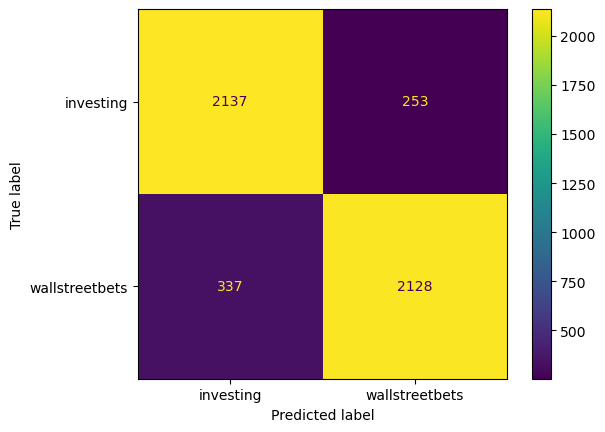

In [68]:
# confusion matrix display
cm = confusion_matrix(y_test, pipe_lr_4.predict(X_test))
cm_display = ConfusionMatrixDisplay(cm, display_labels=pipe_lr_4.classes_).plot()

In [182]:
# percent of wallstreetbets posts correctly classified
print('Percent of WallStreetBets posts correctly classified:', round(cm[0][0] / (cm[0][0] + cm[0][1]), 2))

# percent of investing posts correctly classified
print('Percent of Investing posts correctly classified:', round(cm[1][1] / (cm[1][0] + cm[1][1]), 2))

Percent of WallStreetBets posts correctly classified: 0.89
Percent of Investing posts correctly classified: 0.86


The above confusion matrix is a visual representation of the correct and incorrect classifications our model has made. The diagonal elements are the the correct classifications and the off-diagonal elements are the incorrect observations.

Our model errors slightly more often predicting r/Investing than r/WallStreetBets but is fairly balanced. In order to investigate what use of language might be throwing the model's classifications, we investigate below:

### Common Words in Correct and Incorrect Classifications

In [127]:
prod_results = pd.DataFrame(y_test.copy())

prod_results['text'] = X_test.copy()

prod_results['pred'] = pipe_lr_4.predict(X_test)

prod_results['correct'] = prod_results['subreddit'] == prod_results['pred']

In [190]:
def common_words_right_wrong(df, subreddit, correct):
    '''
    Returns the most common words in a subreddit's posts that were correctly or incorrectly classified.
    '''
    if correct == True:
        df = df.query('subreddit == @subreddit & correct == True')
    else:
        df = df.query('subreddit == @subreddit & correct == False')
    
    cvec = CountVectorizer(stop_words='english', max_features=5000, min_df=2, max_df=0.9, ngram_range=(1,2))
    cvec.fit(df['text'])
    df_cvec = pd.DataFrame(cvec.transform(df['text']).todense(), columns=cvec.get_feature_names_out())
    
    return df_cvec.sum().sort_values(ascending=False).head(20)


Common Words when r/WallStreetBets correctly Classified

In [191]:
# common words in right predictions for wallstreetbets
common_words_right_wrong(prod_results, 'wallstreetbets', True)

buy       1270
make       966
just       948
stock      877
market     830
day        808
like       783
know       750
money      746
https      686
time       677
fuck       651
week       614
think      612
sell       608
good       605
amp        594
option     585
say        570
url        568
dtype: int64

Common words when r/WallStreetBets Incorrectly Classified

In [192]:
common_words_right_wrong(prod_results, 'wallstreetbets', False)

stock      379
company    275
market     250
share      183
year       175
price      171
buy        165
make       162
like       161
url        148
just       147
sell       142
good       133
look       131
say        130
use        129
think      128
million    127
money      126
invest     115
dtype: int64

As we view the most common words from a correct/incorrect r/WallStreetBets classification, we notice a few things. 

**Correct**
1. The presence of profanity
2. The presence of the word option, an investment instrument favored by WallStreetBettors.

**Incorrect**

1. The presence of words like invest
2. The lack of profanity 


Common Words when r/Investing Correctly Classified

In [193]:
common_words_right_wrong(prod_results, 'investing', True)

stock         2193
invest        1519
company       1463
market        1309
year          1257
like          1153
fund           997
just           995
make           933
buy            924
share          913
money          883
good           828
look           811
investment     793
think          764
time           759
know           748
price          740
say            700
dtype: int64

Common Words when r/Investing Incorrectly Classified

In [206]:
common_words_right_wrong(prod_results, 'investing', False)

stock        179
buy          145
market       123
just         120
make         107
url          101
option        99
like          97
tesla         95
think         90
day           88
amp           87
price         77
money         76
time          75
x200b         71
amp x200b     71
sell          70
share         70
know          67
dtype: int64

Above, we see that our model fails to classify r/Investing correctly when the posts make reference to terms more commonly seen in r/WallStreetBets. This includes words such as "day", "option" and "tesla". 

### Feature Importance


In [223]:
# What words are most indicative of a post being from wallstreetbets?

# get coefficients
lr_coef = pipe_lr_4.named_steps['lr'].coef_[0]

# get feature names
lr_features = pipe_lr_4.named_steps['tvec'].get_feature_names_out()

# create dataframe of coefficients and features

lr_coef_df = pd.DataFrame({'coef': lr_coef, 'feature': lr_features})

# sort by coefficient
lr_coef_df.sort_values('coef', ascending=False, inplace=True)

# top 20 coefficients
# lr_coef_df.head(20)

**Polite Society**

The dataframe of coefficients ranked by importance is almost exclusively comprised of words that might be considered hurtful or offensive to potential readers of this notebook. As such, we will not print the output. Curious readers can contact the author or clone this notebook and run the code themselves. Of note however, is the lack of lemmatization amongst these profane words, suggesting NLTK's vocabulary does not include them, and it is possible that predictive accuracy might be lost due to this. 

### ROC and AUC 

Text(0.5, 1.0, 'ROC Curve')

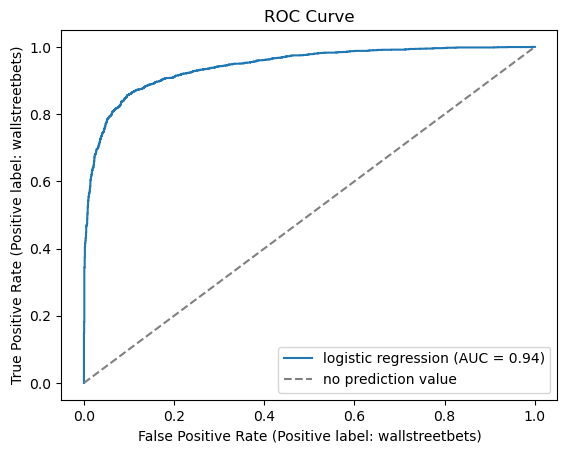

In [71]:
# AUC and ROC
ax = plt.gca()

# Use RocCurveDisplay for both estimators
RocCurveDisplay.from_estimator(lr_gs_3, X_test, y_test, 
                               ax=ax, name='logistic regression')

# Add 'worst case scenario' line
plt.plot([0,1], [0,1], label='no prediction value', 
         linestyle='--', color='gray')
plt.legend()
plt.title('ROC Curve')

The plot above is the ROC curve for our classification model. 

**ROC**

ROC stands for "Receiver Operator Characteristic" and is a graphical representation of the classification ability of a binary classifier. The curve is created by plotting the true positive rate (the proportion of observations that were correctly predicted to be positive) against the false positive rate (the proportion of observations that are incorrectly predicted to be positive out of all negative observations). 

The ROC curve is a quick visual way to assess the trade-off between sensitivity and specificity. The closer the curve is to the upper-left corner, the better the performance of the model. Thus, we see that our model does quite well, as the worst possible model would lie along the 45 degree diagonal line, and our curve sits nicely in the upper left corner of the plot. 

**AUC**

Additionally, we can calculate the Area Under the Curve (AUC), which is the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance. If a classifier is a perfect classifier, it will have a score of 1.0, if a classifier is completely random, it will have a score of 0.5. We see that our model has an AUC score of .94, which is quite good. 

([SOURCE](https://www.displayr.com/what-is-a-roc-curve-how-to-interpret-it/))

# Conclusion

Using a rigorous search and fitting process, we have labored to produce a classification model that can predict whether a post is from r/Investing or r/WallStreetBets with an 87% level of accuracy. This level of accuracy is even better than expected, given the overall level of similarity was assessed at 81% in [notebook_2](2_eda.ipynb). 

From this iterative modeling process we can draw a few conclusions:

1. Logistic Regression was the best performing model across the training and testing data splits amongst the five models we evaluated. 

2. The TF-IDF vectorizer's more nuanced approach to vectorization yielded better results than the Count Vectorizer.

3. We achieve better classification accuracy using title and selftext from subreddit posts rather than one or the other. 

4. Our classification model breaks down when either subreddit uses general investment language. A r/WallStreetBets post devoid of profane language, references to options or short term investment strategies or any of the stock tickers frequently mentioned (such as TSLA or NKLA) becomes difficult to distinguish from a r/Investing post. Conversely, a r/Investing post that centers on options or tickers such as TSLA looks more like a r/WallStreetBets post to the classifier, and accuracy is lost. 

Thus, a high-performance spam-bot would best be programmed to use words that are strongly-r/WSB in a majority of its posts if it was endeavoring to pantomime a r/WallStreetBets post. These words might include options, or other leverage-centric investments terms. The bot should also use emojis such as a '🚀', '🙌', '🐻', '🐂', '💵', '🍗','💎' to reiterate its points or use idiomatic r/WallStreetBets terminology such as "Tendies", Stonks" or acronyms such as "DD" (due diligence). The usage of these phrases or terms lends a post the WallStreetBet-ness that general personal finance posts in r/Investing do not have. Conversely a spam bot can effectively miminc a r/Investint post by *not* using r/WallStreetBets language.

Put simply, a reddit personal finance post is just any other personal finance post *unless* it uses a word like *tendies* and then it immediately self-identifies itself as r/WallStreetBets. 